In [257]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from operator import itemgetter
import more_itertools as mit

#Located at computer
#Define computer box as between x:1450 - 1600, y: 575 - 1700
#Total time under analysis was 1180 seconds.
FRAME_RATE = 29.61              #Average frame rate of the video
TRUNC = 1200                    #Truncate data, clips ends off ~1200 each end, the time it took to reach the top of the forklift.

In [258]:
path_1 = os.path.join("C:\Projects", "huboo", "data", "top_down_pick_and_pack_detection.csv.txt")
data = pd.read_csv(path_1)

path_2 = os.path.join("C:\Projects", "huboo", "data", "associations_top_down_pick_and_pack.csv.txt")
tracklets = pd.read_csv(path_2)

In [259]:
#Manually fix ReId errors
#Man = 1, woman = 2
#21 -> 2

tracklets[" person_id"][7] = 2

In [260]:
identity = pd.merge(data, tracklets, on='tracklet_id', how='left')

person_1 = identity[identity[" person_id"] == 1.0].reset_index()
person_1 = person_1.truncate(before=TRUNC, after=len(person_1)-TRUNC).reset_index()

person_2 = identity[identity[" person_id"] == 2.0].reset_index()
person_2 = person_2.truncate(before=TRUNC, after=len(person_2)-TRUNC).reset_index()

In [261]:
#Position
#Position given by the middle bottom of the box. 
#position = (left, top) + 0.5 * (width, height)

#person_1["position"] = np.array(zip(person_1["l"] + person_1["w"] / 2, person_1["t"] + person_1["h"] / 2))
person_1["x"] = person_1["l"] + person_1["w"] / 2
person_1["y"] = person_1["t"] + person_1["h"] / 2

#person_2["position"] = np.array(zip(person_2["l"] + person_2["w"] / 2, person_2["t"] + person_2["h"] / 2))    #Can add: [1]*len(person_1), if want to transform.
person_2["x"] = person_2["l"] + person_2["w"] / 2
person_2["y"] = person_2["t"] + person_2["h"] / 2

In [262]:
#Locations
#x_min, x_max, y_min, _y_max
#Don't forget that the y-axis is inverted.

COMPUTER_COORD = [1450, 1600, 575, 700]
DESK_COORD = [330, 1600, 575, 700]
AISLE_2_COORD = [700, 900, 20, 400]
AISLE_3_COORD = [1100, 1300, 100, 425]
AISLE_4_COORD = [1500, 1800, 20, 390]
AISLE_BACK_COORD = [0, 1920, -200, 20]
ALL_COORD = [min(data["l"]), max(data["l"]), min(data["t"]), max(data["t"])]

all_regions = {
    "Computer" : COMPUTER_COORD,
    "Desk" : DESK_COORD,
    "Aisle 2" : AISLE_2_COORD,
    "Aisle 3" : AISLE_3_COORD,
    "Aisle 4" : AISLE_4_COORD,
    "Aisle back" : AISLE_BACK_COORD,
    "Other" : ALL_COORD
}


major_regions = {
    "Computer" : COMPUTER_COORD,
    "Desk" : DESK_COORD,
    "Aisles" : (AISLE_2_COORD, AISLE_3_COORD, AISLE_4_COORD, AISLE_BACK_COORD),
    "Other" : ALL_COORD
}

aisle_regions = {
    "Aisle 2" : AISLE_2_COORD,
    "Aisle 3" : AISLE_3_COORD,
    "Aisle 4" : AISLE_4_COORD,
    "Aisle back" : AISLE_BACK_COORD,
}


In [263]:
class PlotFrame():
    
    def __init__(self, df, regions, other=None):
        self.data = df.drop(["level_0", "index", "tracklet_id", "l", "t", "w", "h", "probability_of_detection", " person_id"], axis=1)
        self.regions = regions
        
        for key, value in regions.items():
            name = key
            coords = value

            if type(coords) == list:
                conditions=[(coords[0] < self.data["x"]) & (self.data["x"] < coords[1]) & (coords[2] <self.data["y"]) & (self.data["y"] < coords[3])]
                choices=[1]
            else:
                conditions=[(coord[0] < self.data["x"]) & (self.data["x"] < coord[1]) & (coord[2] < self.data["y"]) & (self.data["y"] < coord[3]) for coord in coords]
                choices=[1]*len(coords)
            
            self.data[name] = np.select(conditions, choices, default = 0).astype('bool')
        
        if other == True:
            subframe = self.data.iloc[:,-len(regions):]
            condition=[subframe.sum(axis=1) == 0]
            choice=[1]
            self.data["Other"] = np.select(condition, choice, default = 0)

            
        #Find strings of activities

    def act_time(self, region):
        #Takes in values (dataframe, activity as string)
        #Returns a dictionary with a tuple of the form (start frame, end frame, time taken) for each instance of the activity.
        iterable = self.data[self.data[region] == True].index.to_series().to_list()
        lists = [list(group) for group in mit.consecutive_groups(iterable)]

        details = {count : (value[0], value[-1], (value[-1] - value[0])/FRAME_RATE) for count, value in enumerate(lists)}

        return details
    
    #Add standardised plotting functions here?


In [250]:
pers2 = PlotFrame(person_1, aisle_regions, other=True)

In [251]:
np.sum(pers2.data["Other"])

29988

In [252]:
pers2.data.iloc[:,-5:]

,Aisle 2,Aisle 3,Aisle 4,Aisle back,Other
0,False,False,False,False,1
1,False,False,False,False,1
2,False,False,False,False,1
3,False,False,False,False,1
4,False,False,False,False,1
...,...,...,...,...,...
31989,False,False,False,False,1
31990,False,False,False,False,1
31991,False,False,False,False,1
31992,False,False,False,False,1


# Plotting

In [264]:
person1 = PlotFrame(person_1, major_regions, other=True)

In [265]:
#Person activity plots
def activity_distribution(df, regions, person):

    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams.update({'font.size': 22})
    
    fig, ax = plt.subplots()
    
    activities = [key for key in regions.keys()]
    times = [np.sum([value[2] for value in act_time(df, region).values()]) for region in activities]    
    colours = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']

    ax.set_title("{} Activity Distribution".format(person))
    ax.set_ylabel("Time (sec)")

    ax.bar(activities, times, color=colours)
    
    return ax

In [270]:
person1.act_time("Aisles")

{0: (3881, 3996, 3.883823032759203),
 1: (6671, 6742, 2.397838568051334),
 2: (16963, 18197, 41.675109760216145),
 3: (28258, 28269, 0.37149611617696726),
 4: (28376, 28946, 19.250253292806484)}

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots()

activities = [key for key in regions.keys()]
times = [np.sum([value[2] for value in act_time(df, region).values()]) for region in activities]    
colours = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']

ax.set_title("{} Activity Distribution".format(person))
ax.set_ylabel("Time (sec)")

ax.bar(activities, times, color=colours)


In [267]:
person1.data

,frame,x,y,Computer,Desk,Aisles,Other
0,2059,1348.100,602.915,False,True,False,0
1,2060,1348.050,603.650,False,True,False,0
2,2061,1347.585,602.795,False,True,False,0
3,2062,1346.510,600.665,False,True,False,0
4,2063,1346.555,601.195,False,True,False,0
...,...,...,...,...,...,...,...
31989,37126,852.015,654.080,False,True,False,0
31990,37127,853.585,653.480,False,True,False,0
31991,37128,855.510,654.585,False,True,False,0
31992,37129,858.460,655.665,False,True,False,0


KeyError: 'computer'

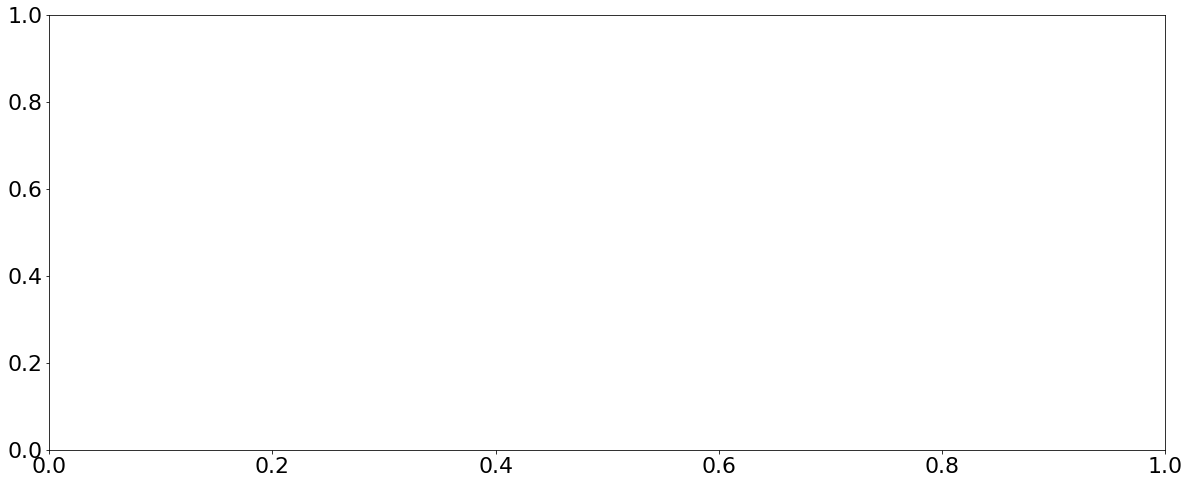

In [268]:
activity_distribution(person_1, regions, "Person 1")

In [ ]:
#Person 1 activity plots



In [ ]:
[key for key in regions.keys()]

In [15]:
np.sum([value[2] for value in act_time(person_1, "aisle 4").values()])

39.41236068895643

In [16]:
activities = [key for key in regions.keys()]
[np.sum([value[2] for value in act_time(person_1, region).values()]) for region in activities]

[198.04120229652145,
 950.7598784194529,
 22.728807835190814,
 0.37149611617696726,
 39.41236068895643,
 4.9983113812901045]

# ARCHIVED CODE

In [ ]:
#Locations

class variant1:

    COMPUTER_COORD = [1450, 1600, 575, 700]
    DESK_COORD = [330, 1600, 575, 700]
    AISLE_2_COORD = [700, 900, 20, 400]
    AISLE_3_COORD = [1100, 1300, 100, 425]
    AISLE_4_COORD = [1500, 1800, 20, 390]
    AISLE_BACK_COORD = [0, 1920, -200, 20]

    regions = {
        "computer" : COMPUTER_COORD,
        "desk" : DESK_COORD,
        "aisle 2" : AISLE_2_COORD,
        "aisle 3" : AISLE_3_COORD,
        "aisle 4" : AISLE_4_COORD,
        "aisle back" : AISLE_BACK_COORD 
    }

class variant2:

    COMPUTER_COORD = [1450, 1600, 575, 700]
    DESK_COORD = [330, 1600, 575, 700]
    AISLE_2_COORD = [700, 900, 20, 400]
    AISLE_3_COORD = [1100, 1300, 100, 425]
    AISLE_4_COORD = [1500, 1800, 20, 390]
    AISLE_BACK_COORD = [0, 1920, -200, 20]

    regions = {
        "computer" : COMPUTER_COORD,
        "desk" : DESK_COORD,
        "aisles" : (AISLE_2_COORD, AISLE_3_COORD, AISLE_4_COORD, AISLE_BACK_COORD)
    }
    
class variant2:

    AISLE_2_COORD = [700, 900, 20, 400]
    AISLE_3_COORD = [1100, 1300, 100, 425]
    AISLE_4_COORD = [1500, 1800, 20, 390]
    AISLE_BACK_COORD = [0, 1920, -200, 20]

    regions = {
        "aisle 2" : AISLE_2_COORD,
        "aisle 3" : AISLE_3_COORD,
        "aisle 4" : AISLE_4_COORD,
        "aisle back" : AISLE_BACK_COORD 
    }


In [ ]:
class PlotFrame():
    
    def __init__(self, daf):
        self.data = daf

    def location(self,regions):
        
        for key, value in regions.items():
            name = key
            coords = value

            if type(coords) == list:
                conditions=[(coords[0] < self.data["x"]) & (self.data["x"] < coords[1]) & (coords[2] <self.data["y"]) & (self.data["y"] < coords[3])]
                choices=[1]
            else:
                conditions=[(coord[0] < self.data["x"]) & (self.data["x"] < coord[1]) & (coord[2] < self.data["y"]) & (self.data["y"] < coord[3]) for coord in coords]
                choices=[1]*len(coords)
            
            self.data[name] = np.select(conditions, choices, default = 0).astype('bool')

In [ ]:
def location(df, coords, name):
    #requires a dataframe with x and y coordinate columns. 
    #coords = [x_left, x_right, y_top, y_bottom]
    #Note y-axis is inverted
    #name is a string
    
    if type(coords) == list:
        conditions=[(coords[0] < df["x"]) & (df["x"] < coords[1]) & (coords[2] < df["y"]) & (df["y"] < coords[3])]
        choices=[1]
    else:
        conditions=[(coord[0] < df["x"]) & (df["x"] < coord[1]) & (coord[2] < df["y"]) & (df["y"] < coord[3]) for coord in coords]
        choices=[1]*len(coords)
    
    df[name] = np.select(conditions, choices, default = 0).astype('bool')

In [ ]:
#Generate location boolean values for the dataframe
for key, value in regions.items():
    location(person_1, value, key)
    
for key, value in regions.items():
    location(person_2, value, key)